In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
import datetime

sns.set()

DATA_DIR = Path('../data/')
pd.set_option('max_columns', 999)

# Loading data

In [2]:
# Extract list of dates, list of calendar filepaths, list of listing filepaths
dates = [re.findall(r'_20(\d{2})-(\d{2})-(\d{2}).*', cal_file.stem)[0] for cal_file in DATA_DIR.iterdir() if 'calendar' in cal_file.stem]
cal_files = [cal_file for cal_file in DATA_DIR.iterdir() if 'calendar' in cal_file.stem]
listing_files = [listing_file for listing_file in DATA_DIR.iterdir() if 'listing' in listing_file.stem]

In [3]:
list(enumerate(dates))

[(0, ('16', '04', '03')),
 (1, ('16', '05', '02')),
 (2, ('16', '06', '02')),
 (3, ('16', '07', '02')),
 (4, ('16', '08', '02')),
 (5, ('16', '09', '02')),
 (6, ('16', '10', '01')),
 (7, ('16', '11', '02')),
 (8, ('16', '12', '03')),
 (9, ('17', '01', '01')),
 (10, ('17', '02', '02')),
 (11, ('17', '03', '02')),
 (12, ('17', '04', '02')),
 (13, ('17', '05', '02')),
 (14, ('17', '06', '02')),
 (15, ('17', '07', '02')),
 (16, ('17', '08', '02')),
 (17, ('17', '09', '02')),
 (18, ('17', '10', '02')),
 (19, ('17', '11', '01')),
 (20, ('17', '12', '02')),
 (21, ('18', '01', '10')),
 (22, ('18', '02', '02')),
 (23, ('18', '03', '04')),
 (24, ('18', '04', '06')),
 (25, ('18', '05', '09'))]

# Pipeline for extracting data for events

In [4]:
def get_cal_data(event_start, event_end, dates, cal_files, listing_files):
    # Initialize final dataframe
    final_cal = None
    
    # Loop through months
    for date, cal, listing in zip(dates, cal_files, listing_files):
        # Read calendar and listings
        data = pd.read_csv(cal, compression='gzip')
        listing_type = pd.read_csv(listing, compression='gzip')[['id', 'room_type']]
        
        # Preprocess dates
        data['date'] = pd.to_datetime(data['date'])
        data['price'] = (
            data
            .loc[:, 'price']
            .str.extract(r'\$(.*)', expand=False)
            .str.replace(r',', '')
            .astype(np.float_)
        )
        
        # Extract subset of calendar corresponding to events
        subset = data[(data['date'] >= event_start) & (data['date'] <= event_end)]
        subset['scraped'] = pd.Timestamp(2000 + int(date[0]), int(date[1]), int(date[2]))
        
        # Left join calendar and listings
        subset = pd.merge(subset, listing_type, left_on='listing_id', right_on='id', how='left')
        
        # Add to final dataframe
        if final_cal is None:
            final_cal = subset
        else:
            final_cal = pd.concat([final_cal, subset])
    
    # For memory purposes
    del data
    return final_cal

In [5]:
def plot_data(cal_data, bins, labels, title):
    # Find unique room type
    room_types = sorted(cal_data['room_type'].unique())
    n_types = len(room_types)
    
    plt.figure(figsize=(25, 7))
    # Iterate over unique room types
    for i, room_type in enumerate(room_types):
        # For subset of room type, find median price per date-scraped combination
        prices = (
            cal_data[cal_data['room_type'] == room_type]
            .groupby(['date', 'scraped'])
            .median()
            .drop(columns=['listing_id', 'id'])
            .reset_index()
        )
        # Assign listing period based on listing date and bins
        prices['Listing period'] = pd.cut(prices['date'], bins=bins, labels=labels)
        
        # Plot lineplot on corresponding subplot
        plt.subplot(1, n_types, i + 1)
        sns.lineplot(data=prices, x='scraped', y='price', hue='Listing period', ci=None)
        plt.xlabel('Booking date')
        plt.ylabel('Price ($)')
        plt.title(title + ', ' + room_type)

# SF Pride

In [6]:
PRIDE_START = pd.Timestamp(2017, 6, 18)
PRIDE_END = pd.Timestamp(2017, 6, 30)

pride_cal = get_cal_data(PRIDE_START, PRIDE_END, dates[3:15], cal_files[3:15], listing_files[3:15])

/mnt/c/Users/Junseo/Documents/data-science/.env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2901: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/mnt/c/Users/Junseo/Documents/data-science/.env/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


/mnt/c/Users/Junseo/Documents/data-science/.env/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


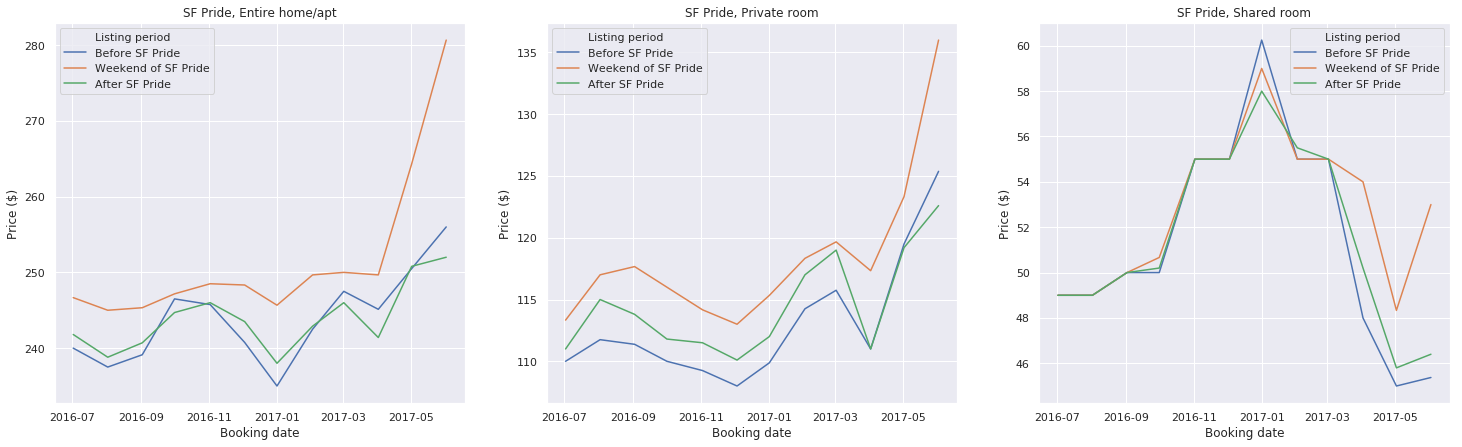

In [7]:
PRIDE_BINS = [PRIDE_START, pd.Timestamp(2017, 6, 22), pd.Timestamp(2017, 6, 25), PRIDE_END]
PRIDE_LABELS = ['Before SF Pride', 'Weekend of SF Pride', 'After SF Pride']

plot_data(pride_cal, bins=PRIDE_BINS, labels=PRIDE_LABELS, title='SF Pride')
plt.savefig('../img/pride/pride.png')

# July 4th

In [8]:
JULY4_START = pd.Timestamp(2017, 6, 26)
JULY4_END = pd.Timestamp(2017, 7, 7)

july4_cal = get_cal_data(JULY4_START, JULY4_END, dates[3:15], cal_files[3:15], listing_files[3:15])

/mnt/c/Users/Junseo/Documents/data-science/.env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2901: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/mnt/c/Users/Junseo/Documents/data-science/.env/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


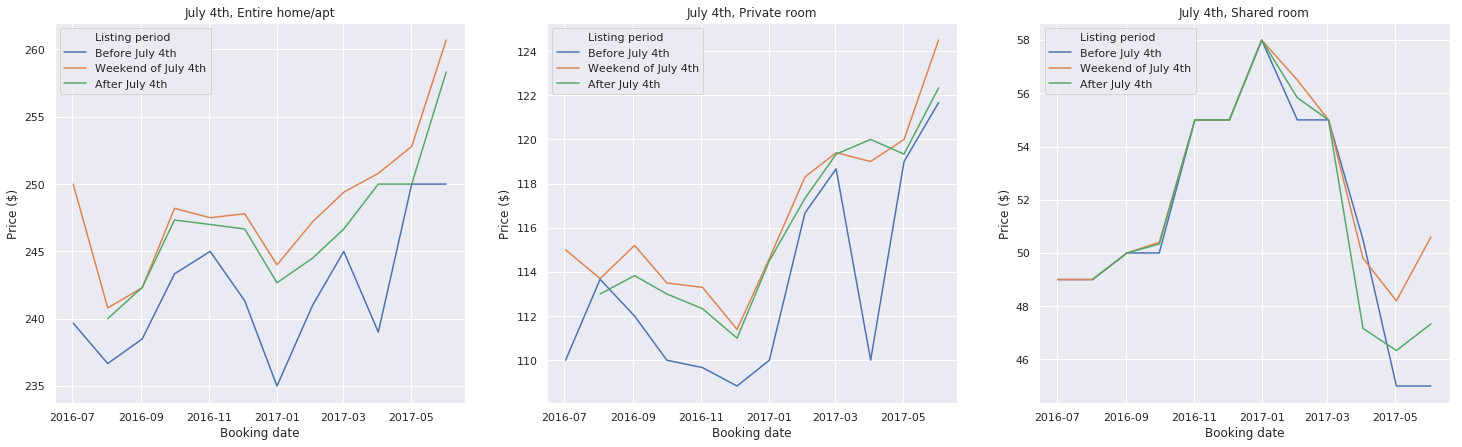

In [9]:
JULY4_BINS = [JULY4_START, pd.Timestamp(2017, 6, 29), pd.Timestamp(2017, 7, 4), JULY4_END]
JULY4_LABELS = ['Before July 4th', 'Weekend of July 4th', 'After July 4th']

plot_data(july4_cal, bins=JULY4_BINS, labels=JULY4_LABELS, title='July 4th')
plt.savefig('../img/july4/july4.png')

# Outside Lands

In [10]:
OSL_START = pd.Timestamp(2017, 8, 7)
OSL_END = pd.Timestamp(2017, 8, 18)

osl_cal = get_cal_data(OSL_START, OSL_END, dates[5:17], cal_files[5:17], listing_files[5:17])

/mnt/c/Users/Junseo/Documents/data-science/.env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2901: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/mnt/c/Users/Junseo/Documents/data-science/.env/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


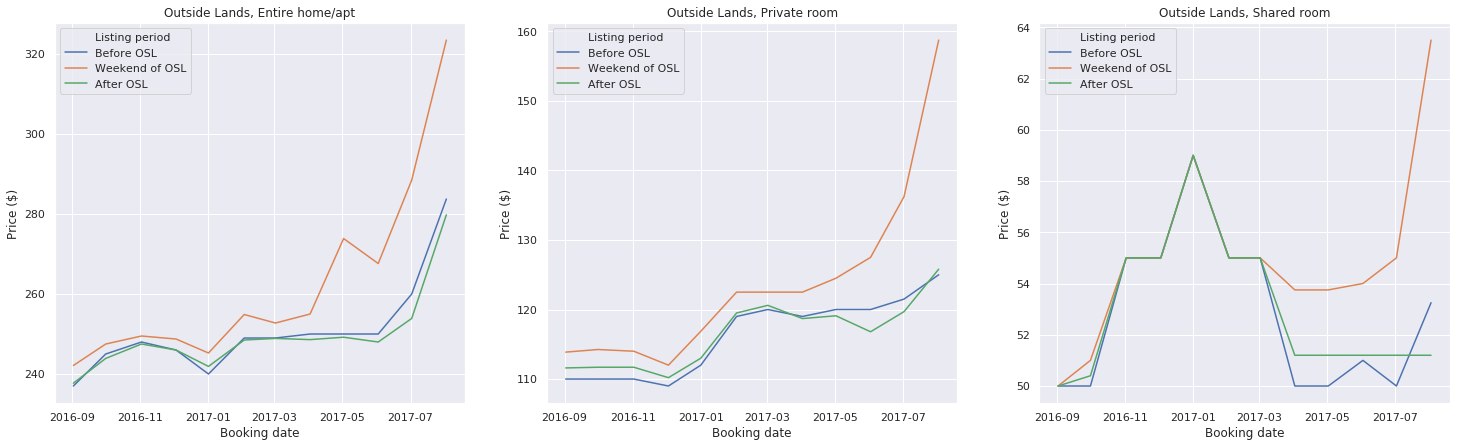

In [11]:
OSL_BINS = [OSL_START, pd.Timestamp(2017, 8, 9), pd.Timestamp(2017, 8, 13), OSL_END]
OSL_LABELS = ['Before OSL', 'Weekend of OSL', 'After OSL']

plot_data(osl_cal, bins=OSL_BINS, labels=OSL_LABELS, title='Outside Lands')
plt.savefig('../img/osl/osl.png')

# Dreamforce

In [12]:
DREAMFORCE_START = pd.Timestamp(2017, 10, 31)
DREAMFORCE_END = pd.Timestamp(2017, 11, 15)

dreamforce_cal = get_cal_data(DREAMFORCE_START, DREAMFORCE_END, dates[8:20], cal_files[8:20], listing_files[8:20])

/mnt/c/Users/Junseo/Documents/data-science/.env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2901: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/mnt/c/Users/Junseo/Documents/data-science/.env/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


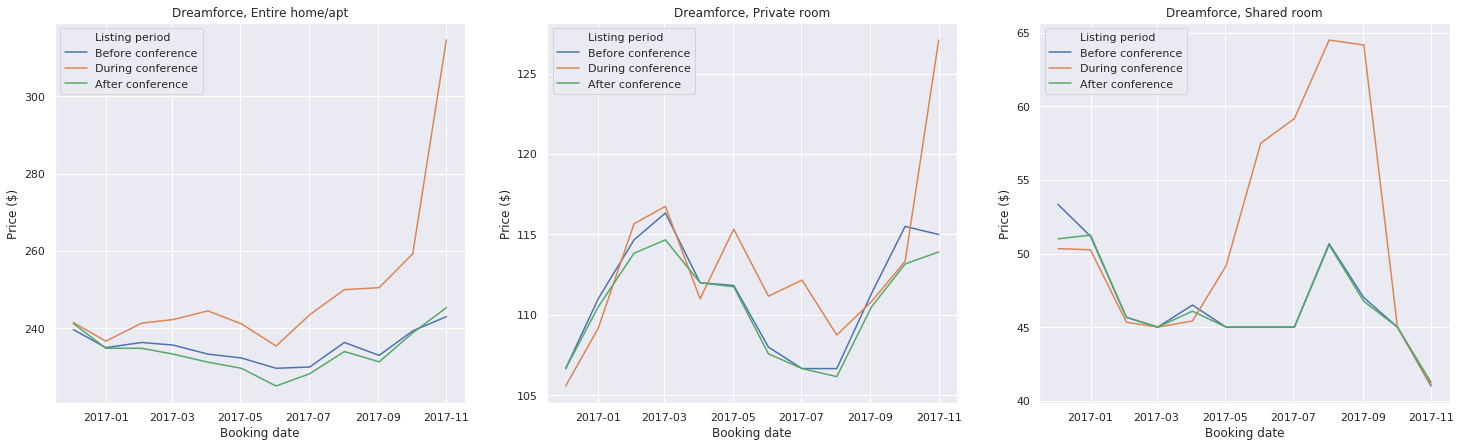

In [13]:
DREAMFORCE_BINS = [DREAMFORCE_START, pd.Timestamp(2017, 11, 3), pd.Timestamp(2017, 11, 9), DREAMFORCE_END]
DREAMFORCE_LABELS = ['Before conference', 'During conference', 'After conference']

plot_data(dreamforce_cal, bins=DREAMFORCE_BINS, labels=DREAMFORCE_LABELS, title='Dreamforce')
plt.savefig('../img/dreamforce/dreamforce.png')

# Christmas/New Years

In [14]:
CHRISTMAS_START = pd.Timestamp(2017, 12, 18)
CHRISTMAS_END = pd.Timestamp(2018, 1, 5)

christmas_cal = get_cal_data(CHRISTMAS_START, CHRISTMAS_END, dates[9:21], cal_files[9:21], listing_files[9:21])

/mnt/c/Users/Junseo/Documents/data-science/.env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2901: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/mnt/c/Users/Junseo/Documents/data-science/.env/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


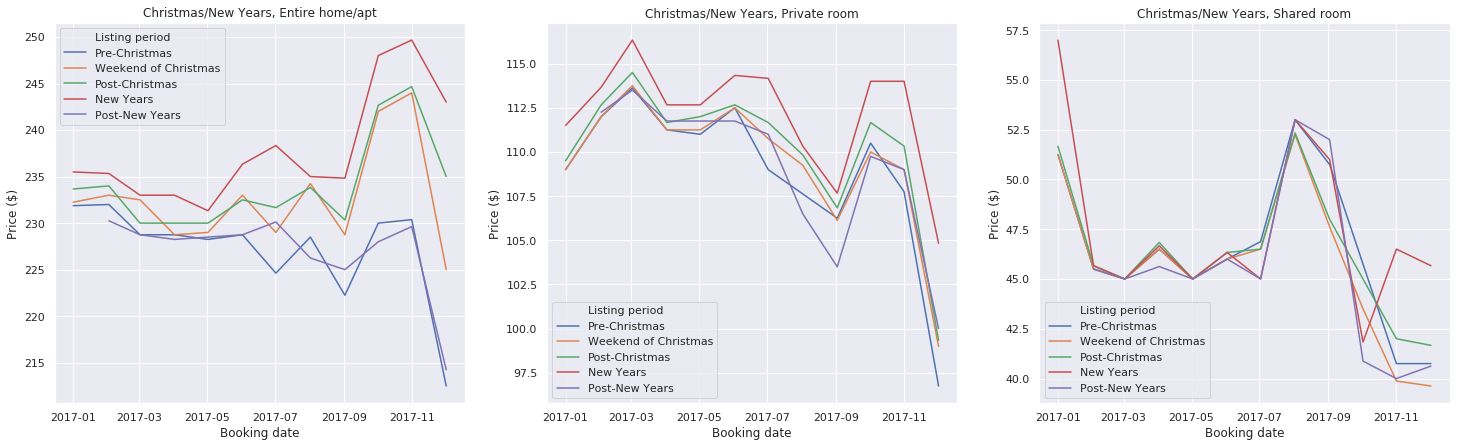

In [15]:
CHRISTMAS_BINS = [CHRISTMAS_START, pd.Timestamp(2017, 12, 22), pd.Timestamp(2017, 12, 26), 
                  pd.Timestamp(2017, 12, 29), pd.Timestamp(2018, 1, 1), CHRISTMAS_END]
CHRISTMAS_LABELS = ['Pre-Christmas', 'Weekend of Christmas', 'Post-Christmas', 'New Years', 'Post-New Years']

plot_data(christmas_cal, bins=CHRISTMAS_BINS, labels=CHRISTMAS_LABELS, title='Christmas/New Years')
plt.savefig('../img/christmas/christmas.png')